In [23]:
import numpy as np
import networkx as nx
import lib.node2vec.node2vec as n2v
import os, csv
import pandas as pd
import pickle

In [2]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from src.constants import STORE_LOCATION
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from src.constants import STORE_LOCATION

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
emb_root = '/Users/prmathur/Documents/Pers/MMDS/Course/CS224W/Project/snap-master/examples/node2vec/emb/'

In [10]:
def read_graph(input, weighted=False, directed=False):
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(input, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not directed:
        G = G.to_undirected()

    return G

In [7]:
def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [map(str, walk) for walk in walks]
    model = Word2Vec(walks, size=args.dimensions, window=args.window_size,\
                     min_count=0, sg=1, workers=args.workers, iter=args.iter)
    model.save_word2vec_format(args.output)
    
    return

In [16]:
tag_dict = {}
with open(os.path.join(STORE_LOCATION, 'graphs/user-tag_keys.txt')) as tg_fl:
    for row in tg_fl:
        k, v = row.strip().split(',')
        tag_dict[float(v.strip())] = k

In [27]:
p, q = 0.25, 0.25

In [28]:
graph_loc = os.path.join(STORE_LOCATION, 'graphs/user-tag.txt')

In [25]:
nx_G = read_graph(graph_loc)

In [31]:
G = n2v.Graph(nx_G, False, p, q)

In [32]:
G.preprocess_transition_probs()

In [35]:
walks = G.simulate_walks(10, 80)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [42]:
np.savez_compressed(os.path.join('data_temp/', 'user-tags-walks.npz'), np.array(walks))

In [40]:
walks = [map(str, walk) for walk in walks]

## Load walks

In [10]:
walks = np.load(os.path.join('data_temp/', 'user-tags-walks.npz'))

In [11]:
walks = walks['arr_0']

In [12]:
walks = walks.tolist()

## Word2Vec

In [1]:
w2v = Word2Vec(walks, size=80, window=8, min_count=0, sg=1, workers=8, iter=5)

NameError: name 'Word2Vec' is not defined

In [15]:
w2v.save_word2vec_format(os.path.join('data_temp/', 'user-tags-emb.emb'))

## Load w2v

In [4]:
w2v = Word2Vec.load_word2vec_format(os.path.join(emb_root, 'ut_p1-q1.emb'), binary=False)

## Clustering

In [250]:
inertias = []
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, n_jobs=-1, precompute_distances=True)
    kmeans.fit(w2v.syn0)
    inertias.append(kmeans.inertia_)

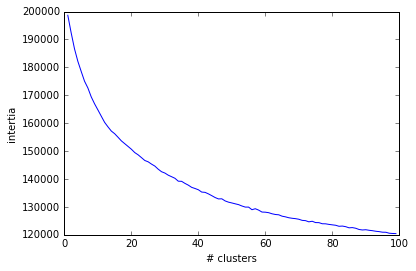

In [284]:
%matplotlib inline
plt.plot(range(1, 100), inertias)
plt.xlabel('# clusters')
plt.ylabel('intertia')

In [5]:
kmeans = KMeans(n_clusters=20, n_jobs=-1, precompute_distances=True)
kmeans.fit(w2v.syn0)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

## T-SNE

In [ ]:
# np.set_printoptions(suppress=False)

tsne = TSNE(n_components=2, random_state=0, n_iter=500, init='pca')

Y_tsne = tsne.fit_transform(w2v.syn0)

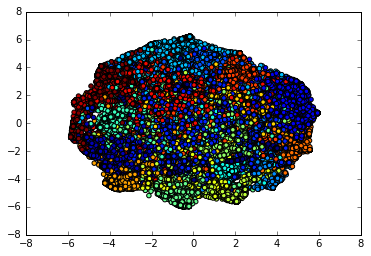

In [275]:
%matplotlib inline
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], c=kmeans.labels_)

## PCA

In [6]:
pca = PCA(n_components=3)

Y_pca = pca.fit_transform(w2v.syn0)

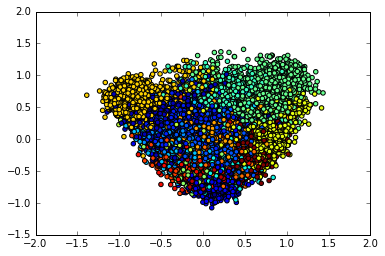

In [8]:
%matplotlib inline
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], c=kmeans.labels_)

In [9]:
tag_ids = [v for v in w2v.vocab.keys() if int(v)>=1000000]

In [10]:
tag_idxs = [w2v.vocab[v].index for v in tag_ids]

In [11]:
Y_pca_tags = Y_pca[tag_idxs]

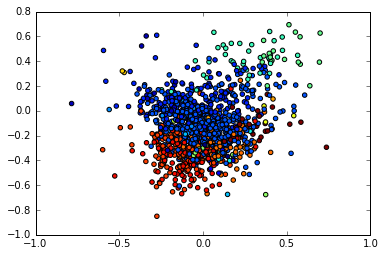

In [12]:
%matplotlib inline
plt.scatter(Y_pca_tags[:, 0], Y_pca_tags[:, 1], c=kmeans.labels_[tag_idxs])

<IPython.core.display.Javascript object>


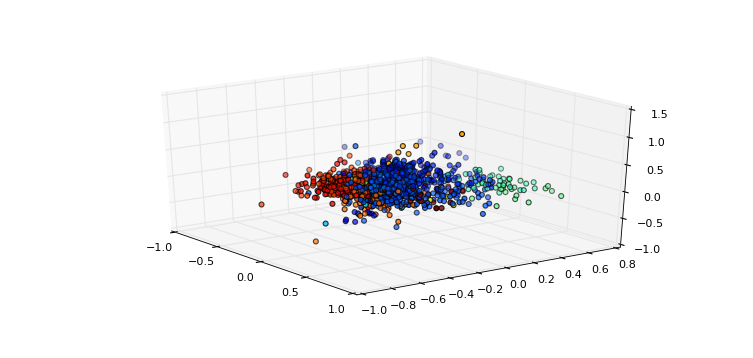

In [14]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y_pca_tags[:, 0], Y_pca_tags[:, 1], Y_pca_tags[:, 2], c=kmeans.labels_[tag_idxs])
plt.draw()

In [17]:
tag_clusters = {}
for t_id, clt in zip(tag_idxs, kmeans.labels_[tag_idxs]):
    tag_name = tag_dict[float(w2v.index2word[t_id])]
    
    if clt in tag_clusters:
        tag_clusters[clt].append(tag_name)
    else:
        tag_clusters[clt] = [tag_name]

In [25]:
with open('data_temp/tag_clusters.pkl', 'wb') as f:
    pickle.dump(tag_clusters, f, pickle.HIGHEST_PROTOCOL)

In [22]:
tag_clusters

{0: ['online-resources', 'book-recommendation', 'reference-request'],
 1: ['fourier-restriction',
  'compactness',
  'metric-spaces',
  'functional-analysis',
  'lp-spaces',
  'strichartz-estimates',
  'compact-operators',
  'set-valued-analysis',
  'banach-algebras',
  'holder-spaces',
  'lebesgue-measure',
  'orlicz-spaces',
  'general-topology',
  'banach-spaces',
  'lebesgue-integral',
  'singular-measures',
  'normed-spaces',
  'measure-theory',
  'analysis',
  '2-categories',
  'bergman-spaces',
  'real-analysis'],
 2: ['career-development',
  'education',
  'advice',
  'mathematicians',
  'learning',
  'big-list',
  'soft-question'],
 3: ['perturbation-theory',
  'interpolation',
  'symmetric-matrices',
  'elliptic-equations',
  'regularization',
  'optimal-transport',
  'harmonic-analysis',
  'billiards',
  'discrete-optimization',
  'closed-graph',
  'hadamard-product',
  'z-transform',
  'octave',
  'fractional-calculus',
  'operations-research',
  'convex-analysis',
  'integ

In [286]:
inertias = []
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, n_jobs=-1, precompute_distances=True)
    kmeans.fit(w2v.syn0[tag_idxs])
    inertias.append(kmeans.inertia_)

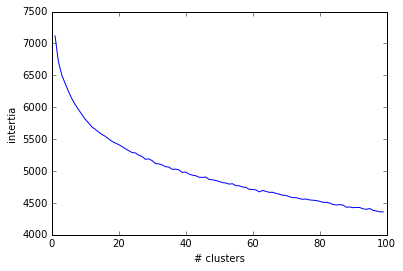

In [287]:
%matplotlib inline
plt.plot(range(1, 100), inertias)
plt.xlabel('# clusters')
plt.ylabel('intertia')